## import the necessary libraries

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

# import pytorch_lightning as pl

try:
    import pytorch_lightning as pl
except ModuleNotFoundError:  # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning >= 1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

try:
    from lightly.data import LightlyDataset
except ModuleNotfoundError:
    !pip install lightly
from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform, utils
from lightning.pytorch.loggers import TensorBoardLogger


In [2]:
image_dir = 'og_data/valid/'
save_dir = 'new_data/valid/'

## prepare the dataset
- load the annotations.json file and crops out the images based on the bounding box coordinates and saves them in a new directory with the annotation_id and category_id
- source of the dataset: https://universe.roboflow.com/yaid-pzikt/firefighting-device-detection/dataset/6
- format of the dataset: COCO json

In [3]:
import csv
import json
from PIL import Image
import os

# Load the JSON file
with open(os.path.join(image_dir, 'annotations.json')) as json_file:
    data = json.load(json_file)

# Open a new CSV file for writing
with open(os.path.join(save_dir, 'annotations.csv'), 'w', newline='') as csv_file:
    # Define the CSV column headers
    fieldnames = ['annotation_id', 'image_id', 'image_file', 'image_height', 'image_width', 'category_id',
                  'category_name', 'bbox_x', 'bbox_y', 'bbox_width', 'bbox_height', 'area', 'iscrowd']

    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    # Loop through each annotation in the JSON og_data
    for annotation in data['annotations']:
        # Get the image and category information related to the annotation
        image = next((item for item in data['images'] if item["id"] == annotation['image_id']), None)
        category = next((item for item in data['categories'] if item["id"] == annotation['category_id']), None)

        # Write the annotation and related information to the CSV
        writer.writerow({
            'annotation_id': annotation['id'],
            'image_id': image['id'] if image else None,
            'image_file': image['file_name'] if image else None,
            'image_height': image['height'] if image else None,
            'image_width': image['width'] if image else None,
            'category_id': category['id'] if category else None,
            'category_name': category['name'] if category else None,
            'bbox_x': annotation['bbox'][0],
            'bbox_y': annotation['bbox'][1],
            'bbox_width': annotation['bbox'][2],
            'bbox_height': annotation['bbox'][3],
            'area': annotation['area'],
            'iscrowd': annotation['iscrowd']
        })

# Load the JSON file
with open(os.path.join(image_dir, 'annotations.json')) as f:
    data = json.load(f)

categories = data['categories']
# create a map of category_id to category_name
category_map = {category['id']: category['name'] for category in categories}

# Process each annotation
for annotation in data['annotations']:
    image_id = annotation['image_id']
    annotation_id = annotation['id']
    bbox = annotation['bbox']
    category_id = annotation['category_id']
    category_name = category_map[category_id]

    # Find the corresponding image file
    image_file = next((item for item in data['images'] if item["id"] == image_id), None)
    if not image_file:
        continue  # Skip if the image is not found

    # Open the image
    image_path = f"{image_dir}{image_file['file_name']}"
    with Image.open(image_path) as img:
        # Calculate the bounding box coordinates
        x, y, width, height = bbox
        area = (x, y, x + width, y + height)

        # Crop the image
        cropped_img = img.crop(area)

        # Save the cropped image with a name that includes annotation_id and attributes
        filename = f"{save_dir}annotation_{annotation_id}_category_{category_id}_{category_name}.jpg"
        cropped_img.save(filename)

print("Cropping completed.")


Cropping completed.


## set the seed for future reproduciability


In [4]:
pl.seed_everything(69420)

path_to_data = "new_data/train/"
path_to_test_data = "new_data/test/"
path_to_valid_data = "new_data/valid/"

Seed set to 69420


## see further below for the hyperparameters validation

In [5]:

num_workers = 8
batch_size = 32
seed = 1
max_epochs = 5
input_size = 128
num_ftrs = 32

## fit the dataset for the model

In [6]:
transform = SimCLRTransform(input_size=input_size, vf_prob=0.5, rr_prob=0.5)

# We create a torchvision transformation for embedding the dataset after
# training
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

dataset_train_simclr = LightlyDataset(input_dir=path_to_data, transform=transform)

dataset_test = LightlyDataset(input_dir=path_to_test_data, transform=test_transform)
dataset_valid = LightlyDataset(input_dir=path_to_valid_data, transform=transform)

dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

print(len(dataloader_train_simclr))
print(len(dataloader_test))
print(len(dataloader_valid))

81
14
24


## SimCLR model implementation

ResNet-18 backbone was used out of convenience due to available documentation and online resources

In [7]:
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    # def training_step(self, batch, batch_idx):
    #     (x0, x1), _, _ = batch
    #     z0 = self.forward(x0)
    #     z1 = self.forward(x1)
    #     loss = self.criterion(z0, z1)
    #     self.log("train_loss_ssl", loss)
    #
    #     if batch_idx == 0:  # Every 10 epochs, print loss for first batch
    #         print(f"Epoch: {self.current_epoch}, Loss: {loss.item()}")
    #     return loss

    #
    # def validation_step(self, batch, batch_idx):
    #     (x0, x1), _, _ = batch
    #     z0 = self.forward(x0)
    #     z1 = self.forward(x1)
    #     loss = self.criterion(z0, z1)
    #     self.log("val_loss_ssl", loss)
    #
    #     return loss

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        # x0, x1, fnames = batch

        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)

        if batch_idx == 0:  # Optionally, log or print loss for the first batch
            print(f"Epoch: {self.current_epoch}, Loss: {loss.item()}")
        return loss

    def validation_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("val_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

## train the model

In [8]:
model = SimCLRModel()
logger = TensorBoardLogger("lightning_logs", name="my_model")
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu", logger=logger)
# print(len(dataset_train_simclr))
# trainer.fit(model, dataloader_train_simclr)
trainer.fit(model, dataloader_train_simclr, dataloader_valid)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\oof\PycharmProjects\pythonProject3\venv2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
C:\Users\oof\PycharmProjects\pythonProject3\venv2\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
C:\Users\oof\PycharmProjects\pythonProject3\venv2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Epoch: 0, Loss: 4.021990776062012


Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\oof\PycharmProjects\pythonProject3\venv2\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 19. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch: 1, Loss: 3.9326486587524414


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 2, Loss: 3.7407469749450684


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 3, Loss: 3.846560001373291


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 4, Loss: 3.729687452316284


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


## loop to try out different hyperparameters and visualize the results
uncomment the code at the bottom of this cell to run the hyperparameter search

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch: 0, Loss: 4.191229343414307


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 1, Loss: 3.8228280544281006


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 2, Loss: 3.8575527667999268


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 3, Loss: 3.856370687484741


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 4, Loss: 4.258130073547363


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_loss_ssl           3.855616569519043
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch: 0, Loss: 4.202489852905273


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 1, Loss: 3.8555588722229004


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 2, Loss: 3.918323278427124


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 3, Loss: 3.7507405281066895


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 4, Loss: 3.6378321647644043


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_loss_ssl          3.8162145614624023
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch: 0, Loss: 4.103116989135742


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 1, Loss: 4.01815938949585


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 2, Loss: 4.035257816314697


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 3, Loss: 3.813288927078247


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 4, Loss: 3.9605884552001953


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_loss_ssl          3.8229918479919434
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\oof\PycharmProjects\pythonProject3\venv2\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
C:\Users\oof\PycharmProjects\pythonProject3\venv2\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Epoch: 0, Loss: 4.8197832107543945


Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\oof\PycharmProjects\pythonProject3\venv2\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 51. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch: 1, Loss: 4.541024208068848


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 2, Loss: 4.803427696228027


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 3, Loss: 4.734630584716797


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 4, Loss: 4.506941795349121


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_loss_ssl           4.567334175109863
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch: 0, Loss: 4.796115875244141


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 1, Loss: 4.6408610343933105


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 2, Loss: 4.643270969390869


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 3, Loss: 4.62835168838501


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 4, Loss: 4.711974620819092


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_loss_ssl           4.607781887054443
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch: 0, Loss: 4.89934778213501


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 1, Loss: 4.517621040344238


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 2, Loss: 4.510456085205078


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 3, Loss: 4.681739330291748


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 4, Loss: 4.58596658706665


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_loss_ssl           4.450341701507568
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\oof\PycharmProjects\pythonProject3\venv2\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
C:\Users\oof\PycharmProjects\pythonProject3\venv2\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Epoch: 0, Loss: 5.536074161529541


Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\oof\PycharmProjects\pythonProject3\venv2\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 115. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch: 1, Loss: 5.5061235427856445


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 2, Loss: 5.6066083908081055


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 3, Loss: 5.273156642913818


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 4, Loss: 5.377374172210693


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_loss_ssl          5.2624287605285645
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch: 0, Loss: 5.55230712890625


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 1, Loss: 5.522119045257568


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 2, Loss: 5.3628458976745605


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 3, Loss: 5.252471923828125


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 4, Loss: 5.276695251464844


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_loss_ssl           5.176498889923096
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch: 0, Loss: 5.603625297546387


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 1, Loss: 5.3585405349731445


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 2, Loss: 5.418847560882568


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 3, Loss: 5.181897163391113


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 4, Loss: 5.1257429122924805


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_loss_ssl           5.076402187347412
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
(32, 64, tensor(3.8162))


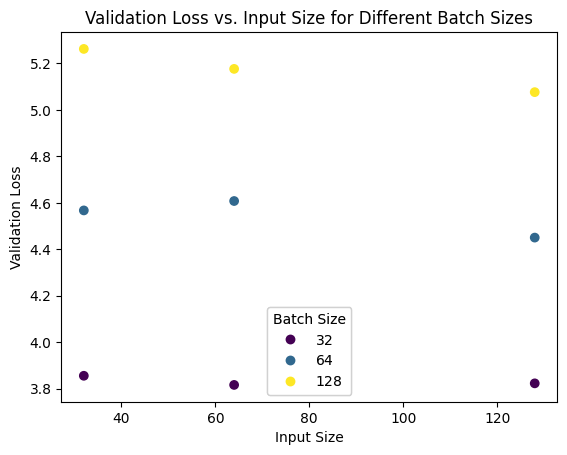

In [9]:
from torch import tensor

max_epochs = 5
batch_size_list = [32, 64, 128]
input_size_list = [32, 64, 128]


def hyperparameter_search(batch_size_list, input_size_list):
    results = []
    for batch_size in batch_size_list:
        for input_size in input_size_list:


            transform = SimCLRTransform(input_size=input_size, vf_prob=0.5, rr_prob=0.5)

            # We create a torchvision transformation for embedding the dataset after
            # training
            test_transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize((input_size, input_size)),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(
                        mean=utils.IMAGENET_NORMALIZE["mean"],
                        std=utils.IMAGENET_NORMALIZE["std"],
                    ),
                ]
            )

            dataset_train_simclr = LightlyDataset(input_dir=path_to_data, transform=transform)

            dataset_test = LightlyDataset(input_dir=path_to_test_data, transform=test_transform)
            dataset_valid = LightlyDataset(input_dir=path_to_valid_data, transform=transform)

            dataloader_train_simclr = torch.utils.data.DataLoader(
                dataset_train_simclr,
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=num_workers)

            dataloader_test = torch.utils.data.DataLoader(
                dataset_test,
                batch_size=batch_size,
                shuffle=False,
                drop_last=False,
                num_workers=num_workers)
            dataloader_valid = torch.utils.data.DataLoader(
                dataset_valid,
                batch_size=batch_size,
                shuffle=False,
                drop_last=False,
                num_workers=num_workers)

            model = SimCLRModel()
            logger = TensorBoardLogger("lightning_logs", name="my_model")
            trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu", logger=logger)
            # print(len(dataset_train_simclr))
            trainer.fit(model, dataloader_train_simclr, dataloader_valid)
            trainer.validate(model, dataloader_valid)
            results.append((batch_size, input_size, trainer.callback_metrics['val_loss_ssl']))

    return results


# results = [(32, 32, tensor(3.8684)), (32, 64, tensor(3.8427)), (32, 128, tensor(3.8327)), (64, 32, tensor(4.5009)), (64, 64, tensor(4.5131)), (64, 128, tensor(4.5805)), (128, 32, tensor(5.1350)), (128, 64, tensor(5.1485)), (128, 128, tensor(5.2738))]


# hyperparameter_search(batch_size_list, input_size_list)
def find_best_hyperparameters(results):
    """
    Find the hyperparameters (batch size and input size) that result in the lowest loss.

    Parameters:
    results (list of tuples): Each tuple contains (batch_size, input_size, loss).

    Returns:
    tuple: The tuple containing the best batch size, input size, and the corresponding lowest loss.
    """
    # Sort the results by loss
    sorted_results = sorted(results, key=lambda x: x[2].item())

    # Return the first tuple which will have the lowest loss
    return sorted_results[0]


# plot the results
def plot_results(results):
    # Extracting the data
    batch_sizes = [x[0] for x in results]
    input_sizes = [x[1] for x in results]
    losses = [x[2].item() for x in results]

    # Creating a scatter plot
    fig, ax = plt.subplots()
    scatter = ax.scatter(input_sizes, losses, c=batch_sizes, cmap='viridis')

    # Adding labels and title
    ax.set_xlabel('Input Size')
    ax.set_ylabel('Validation Loss')
    ax.set_title('Validation Loss vs. Input Size for Different Batch Sizes')

    # Adding a legend for batch sizes
    legend1 = ax.legend(*scatter.legend_elements(), title="Batch Size")
    ax.add_artist(legend1)

    plt.show()

results = hyperparameter_search(batch_size_list, input_size_list)
best_hyperparameters = find_best_hyperparameters(results)
print(best_hyperparameters)
plot_results(results)


## prepare the model for testing by generating the embeddings

In [10]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, _, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


model.eval()
embeddings, test_filenames = generate_embeddings(model, dataloader_test)

## test 1: k nearest neighbors

In [11]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array"""
    img = Image.open(filename)
    return np.asarray(img)


def knn_test(embeddings, filenames, n_neighbors=3):
    """test the accuracy of the embeddings using the k-nearest neighbors on the testing dataloader set
    for each of the filenames, we will find the n_neighbors closest images and check if the classes
    of the closest images are the same as the class of the original image
    """
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)
    samples_idx = [i for i in range(len(indices))]
    correct = 0

    def extract_last_words(filename):
        """
        Extract the words after the last underscore in the filename, before the file extension.

        Parameters:
        filename (str): The filename from which to extract the words.

        Returns:
        str: The extracted words.
        """
        # Remove the file extension
        name_without_extension = filename.rsplit('.', 1)[0]

        # Extract the last words after the last underscore
        last_words = name_without_extension.split('_')[-1]

        return last_words


    res = []
    for idx in samples_idx:
        # loop through their nearest neighbors
        for neighbor_idx in indices[idx]:
            expected_category = extract_last_words(filenames[idx][:-7])
            neighbor_category = extract_last_words(filenames[neighbor_idx][:-7])
            # print(f"Original: {expected_category}, Neighbor: {neighbor_category}")
            if expected_category == neighbor_category:
                correct += 1
                res.append((expected_category, neighbor_category))
    print(f"Accuracy: {correct / (len(samples_idx) * n_neighbors)}")

knn_test(embeddings, test_filenames)



Accuracy: 0.8710691823899371


## test 2: visualize the k nearest neighbors


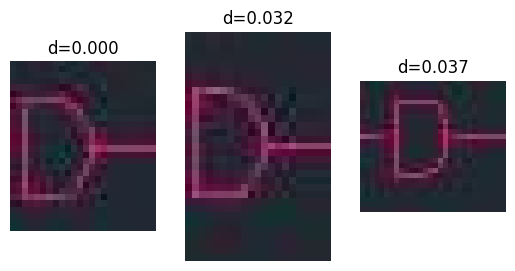

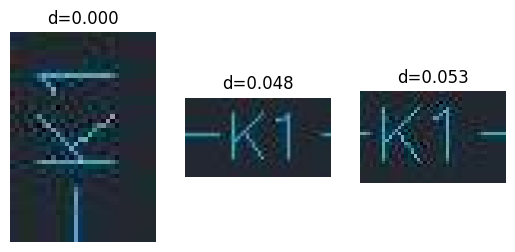

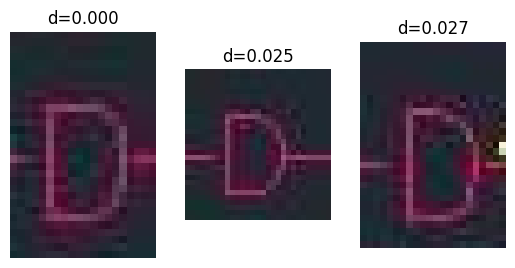

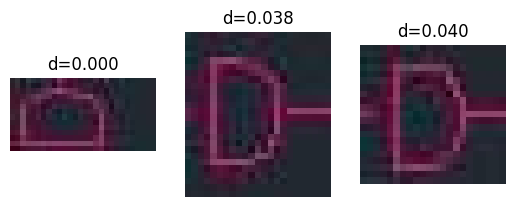

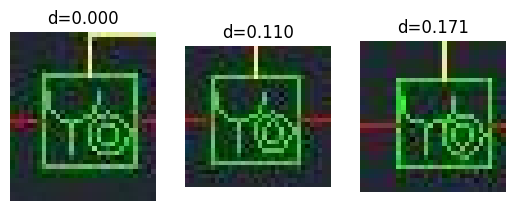

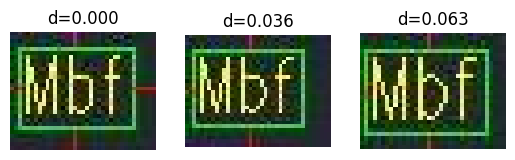

In [12]:
def plot_knn_examples(embeddings, filenames, n_neighbors=3, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_test_data, filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            # let's disable the axis
            plt.axis("off")

plot_knn_examples(embeddings, test_filenames)
